In [1]:
#import packages
import pandas as pd
import keras
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import save_model

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
#read train data
data = pd.read_csv(r"train.csv")
data.shape

(20800, 5)

In [4]:
#print top 3 rows
data.head(3)

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1

In [5]:
#information about train data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
#droping na data
data = data.dropna()
data.shape

(18285, 5)

In [7]:
#features
X = data.drop("label",axis=1)
X.shape

(18285, 4)

In [8]:
#label/target
y = data["label"]
y.shape

(18285,)

In [9]:
import re #for regular espression
from nltk.corpus import stopwords #for stopword remove
from nltk.stem.porter import PorterStemmer #for stemming

In [10]:
message = X.copy()
message.head(3)

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   

                                                text  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  
1  Ever get the feeling your life circles the rou...  
2  Why the Truth Might Get You Fired October 29, ...

In [11]:
#reset index because we removed na rows
message.reset_index(inplace=True)
message.head(3)

index  id                                              title  \
0      0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1      1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2      2   2                  Why the Truth Might Get You Fired   

               author                                               text  
0       Darrell Lucus  House Dem Aide: We Didn’t Even See Comey’s Let...  
1     Daniel J. Flynn  Ever get the feeling your life circles the rou...  
2  Consortiumnews.com  Why the Truth Might Get You Fired October 29, ...

In [12]:
#creating corpus
ps = PorterStemmer()
corpus = []
for i in range(0, len(message)):
    review = re.sub('[^a-zA-Z]', ' ', message['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [13]:
corpus[0:5]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri']

In [14]:
#onehot Representation
voc_size = 5000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [15]:
onehot_repr[0:5]

[[2816, 1513, 644, 3727, 1089, 224, 3435, 4460, 3151, 3192],
 [1332, 1182, 1541, 3468, 3833, 4067, 3727],
 [4520, 4032, 795, 1468],
 [4530, 3416, 2542, 94, 3088, 1890],
 [92, 3833, 465, 3289, 2890, 1932, 3833, 4519, 3274, 1547]]

In [16]:
#Embedding Representation
sent_len = 20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_len)
print(embedded_docs)

[[   0    0    0 ... 4460 3151 3192]
 [   0    0    0 ... 3833 4067 3727]
 [   0    0    0 ... 4032  795 1468]
 ...
 [   0    0    0 ... 4890 2450 4820]
 [   0    0    0 ... 1977 1549   75]
 [   0    0    0 ... 4623 3826 1549]]


In [17]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2816,
       1513,  644, 3727, 1089,  224, 3435, 4460, 3151, 3192], dtype=int32)

In [18]:
from keras.layers import Dropout
#creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
model.add(Dropout(0.6))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256501 (1001.96 KB)
Trainable params: 256501 (1001.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)
X_final.shape,y_final.shape

((18285, 20), (18285,))

In [20]:
#split data into train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.4, random_state=42)

In [21]:
#training/ fit the model
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
172/172 [==============================] - 3s 15ms/step - loss: 0.3713 - accuracy: 0.8293 - val_loss: 0.2231 - val_accuracy: 0.9018
Epoch 2/10
172/172 [==============================] - 2s 14ms/step - loss: 0.1739 - accuracy: 0.9296 - val_loss: 0.1923 - val_accuracy: 0.9176
Epoch 3/10
172/172 [==============================] - 2s 14ms/step - loss: 0.1304 - accuracy: 0.9530 - val_loss: 0.2076 - val_accuracy: 0.9178
Epoch 4/10
172/172 [==============================] - 2s 13ms/step - loss: 0.1080 - accuracy: 0.9593 - val_loss: 0.2085 - val_accuracy: 0.9152
Epoch 5/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0857 - accuracy: 0.9688 - val_loss: 0.2311 - val_accuracy: 0.9143
Epoch 6/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0731 - accuracy: 0.9731 - val_loss: 0.2545 - val_accuracy: 0.9171
Epoch 7/10
172/172 [==============================] - 2s 13ms/step - loss: 0.0584 - accuracy: 0.9795 - val_loss: 0.2605 - val_accuracy: 0.9165

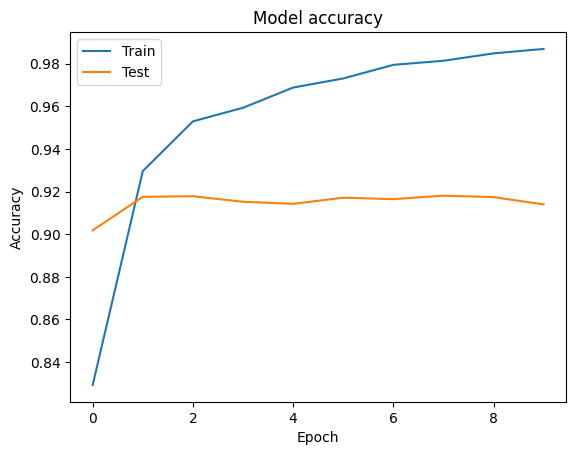

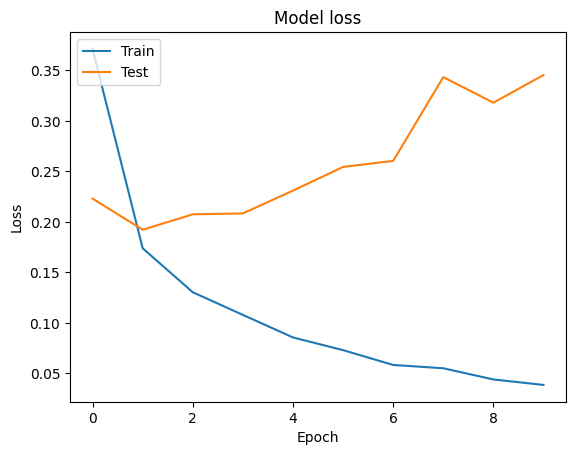

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
model.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [24]:
## Creating model with dropout
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
model1.add(LSTM(100))
model1.add(Dense(1,activation='relu'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256501 (1001.96 KB)
Trainable params: 256501 (1001.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [25]:
#training/ fit the model
history = model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=64)


Epoch 1/15
172/172 [==============================] - 3s 15ms/step - loss: 0.4169 - accuracy: 0.8255 - val_loss: 0.2405 - val_accuracy: 0.9065
Epoch 2/15
172/172 [==============================] - 2s 14ms/step - loss: 0.1949 - accuracy: 0.9369 - val_loss: 0.2944 - val_accuracy: 0.9102
Epoch 3/15
172/172 [==============================] - 2s 14ms/step - loss: 0.1613 - accuracy: 0.9546 - val_loss: 0.4077 - val_accuracy: 0.8970
Epoch 4/15
172/172 [==============================] - 3s 15ms/step - loss: 0.1361 - accuracy: 0.9695 - val_loss: 1.0193 - val_accuracy: 0.7483
Epoch 5/15
172/172 [==============================] - 2s 14ms/step - loss: 0.1343 - accuracy: 0.9642 - val_loss: 0.6791 - val_accuracy: 0.9129
Epoch 6/15
172/172 [==============================] - 2s 14ms/step - loss: 0.0837 - accuracy: 0.9871 - val_loss: 0.6006 - val_accuracy: 0.8970
Epoch 7/15
172/172 [==============================] - 2s 14ms/step - loss: 0.0750 - accuracy: 0.9909 - val_loss: 0.7930 - val_accuracy: 0.9113

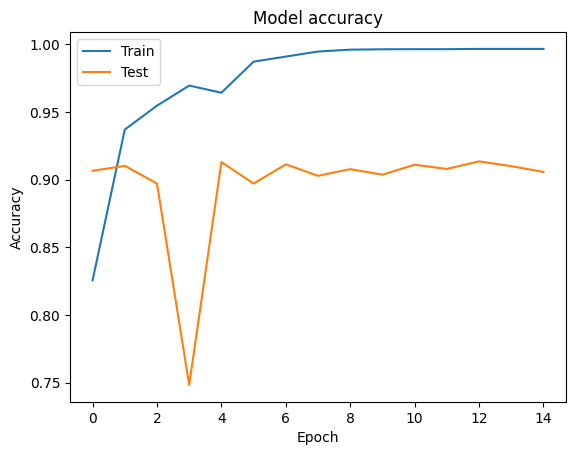

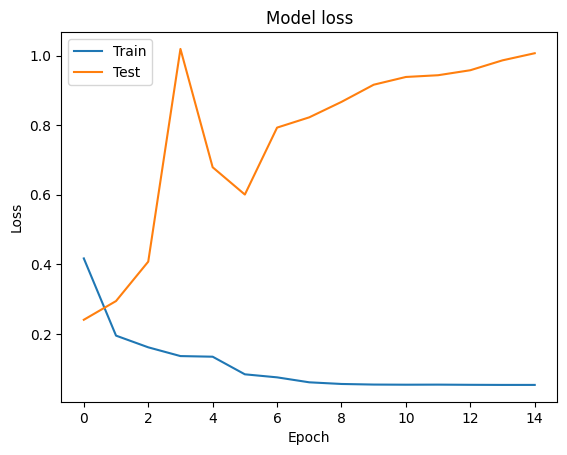

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
model.save("model1")

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets
